# Example Project: **Classification and Captioning Aircraft Damage Using Pretrained Models**

## **Overview**

Aircraft damage detection is essential for maintaining the safety and longevity of aircraft. Traditional manual inspection methods are time-consuming and prone to human error. This project aims to automate the classification of aircraft damage into two categories: "dent" and "crack."

We will use feature extraction with a pre-trained VGG16 model to classify the damage from aircraft images. Additionally, we will use a pre-trained Transformer model to generate captions and summaries for the images.

The goal is to develop an automated model that accurately classifies aircraft damage from images. This model would be applicable in real-world damage detection within the aviation industry. And will showcase how we can use a Transformer-based model to caption and summarize images, providing a detailed description of the damage.

In [1]:
# Import Required Libraries

import zipfile
import keras
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Flatten
from keras.applications import VGG16
from keras.optimizers import Adam
from keras.preprocessing import image
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
import numpy as np
import random

In [2]:
# Set seed for reproducibility

seed_value = 42
random.seed(seed_value)
np.random.seed(seed_value)
tf.random.set_seed(seed_value)

### Pretrained Model

A pretrained model refers to a machine learning model that has already been trained on a large dataset, typically for a specific task, and is ready for use or fine-tuning on a new task or dataset. The key idea behind a pretrained model is that it has already learned useful patterns or features from the data it was trained on, so you don’t need to start from scratch.

- **ResNet, VGG (Image Classification):** These are pretrained models commonly used for image classification tasks. They have learned from millions of images and can be fine-tuned for specific image-related tasks.

- **BLIP (Image Captioning and Summarization):** BLIP is a pretrained model that can generate captions and summaries for images. It has already been trained on image-text pairs, so it can easily generate descriptive captions for new images.

## DATA

We will be using the [Aircraft dataset](https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/ZjXM4RKxlBK9__ZjHBLl5A/aircraft-damage-dataset-v1.tar).
Dataset Original Source: [Roboflow Aircraft Dataset](https://universe.roboflow.com/youssef-donia-fhktl/aircraft-damage-detection-1j9qk) provided by a Roboflow user, License: CC BY 4.

In [3]:
# Extract the Dataset: Unzip the dataset to the current directory.

import tarfile
import urllib.request
import os
import shutil

# URL of the tar file
url = "https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/ZjXM4RKxlBK9__ZjHBLl5A/aircraft-damage-dataset-v1.tar"

# Define the path to save the file
tar_filename = "aircraft_damage_dataset_v1.tar"
extracted_folder = "aircraft_damage_dataset_v1"  # Folder where contents will be extracted

# Download the tar file
urllib.request.urlretrieve(url, tar_filename)
print(f"Downloaded {tar_filename}. Extraction will begin now.")

# Check if the folder already exists
if os.path.exists(extracted_folder):
    print(f"The folder '{extracted_folder}' already exists. Removing the existing folder.")

    # Remove the existing folder to avoid overwriting or duplication
    shutil.rmtree(extracted_folder)
    print(f"Removed the existing folder: {extracted_folder}")

# Extract the contents of the tar file
with tarfile.open(tar_filename, "r") as tar_ref:
    tar_ref.extractall()  # This will extract to the current directory
    print(f"Extracted {tar_filename} successfully.")


Downloaded aircraft_damage_dataset_v1.tar. Extraction will begin now.
Extracted aircraft_damage_dataset_v1.tar successfully.


The folder structure looks as follows:

```python
aircraft_damage_dataset_v1/
├── train/
│   ├── dent/
│   └── crack/
├── valid/
│   ├── dent/
│   └── crack/
└── test/
    ├── dent/
    └── crack/

```


In [4]:
# Define directories for train, test, and validation splits

extract_path = "aircraft_damage_dataset_v1"
train_dir = os.path.join(extract_path, 'train')
test_dir = os.path.join(extract_path, 'test')
valid_dir = os.path.join(extract_path, 'valid')

### Data Preprocessing

Create data generators for training, validation, and testing datasets.

The ImageDataGenerator class, part of Keras, is a utility for real-time image data augmentation, preprocessing, and feeding data into deep learning models. This class is particularly useful when working with image datasets that are too large to fit into memory all at once, or when you want to augment your dataset to improve model generalization.

We will create instances of the ImageDataGenerator class. Each instance corresponds to one of the datasets: training, validation, and testing.

In [5]:
# Create ImageDataGenerators to preprocess the data.

train_datagen = ImageDataGenerator(rescale=1./255)
valid_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

In [7]:
# Set the batch size and epochs.

batch_size = 32
n_epochs = 5
img_rows, img_cols = 224, 224
input_shape = (img_rows, img_cols, 3)

We use flow_from_directory() method to load the images from directory and generate the training dataset. The flow_from_directory() method is part of the ImageDataGenerator class in Keras, and it plays a crucial role in automating the process of loading, preprocessing, and batching images for training, validation, and testing.

We use the train_datagen object to load and preprocess the training images. Specifically, the flow_from_directory() function is used to read images directly from the directory and generate batches of data that will be fed into the model for training.

In [8]:
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(img_rows, img_cols),   # Resize images to the size VGG16 expects
    batch_size=batch_size,
    seed = seed_value,
    class_mode='binary',
    shuffle=True # Binary classification: dent vs crack
)

Found 300 images belonging to 2 classes.


In [9]:
# Create a valid_generator using the valid_datagen object.

valid_generator =  valid_datagen.flow_from_directory(
    directory=valid_dir,
    class_mode='binary',
    seed=seed_value,
    batch_size=batch_size,
    shuffle=False,
    target_size=(img_rows, img_cols)
)

Found 96 images belonging to 2 classes.


In [11]:
# Create a test_generator using the test_datagen object.

test_generator =  test_datagen.flow_from_directory(
    directory=test_dir,
    class_mode='binary',
    seed=seed_value,
    batch_size=batch_size,
    shuffle=False,
    target_size=(img_rows, img_cols)
)

Found 50 images belonging to 2 classes.


## Classification Problem

Classifying the defect on the aircraft as 'dent' or 'crack'.

### Model Definition

Define the model architecture using a pre-trained VGG16 model as the base, adding custom layers for binary classification of 'dent' and 'crack' types of damage.

In [12]:
# Load the pre-trained model VGG16.

base_model = VGG16(weights='imagenet', include_top=False, input_shape=(img_rows, img_cols, 3))

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


**Modify the VGG16 model for our specific classification task.**

Extract the output from the last layer of the pre-trained VGG16 model, and then create a new model with this modified output.

We will freeze the base VGG16 model layers so that their weights will not be updated during training.

In [13]:
output = base_model.layers[-1].output
output = keras.layers.Flatten()(output)
base_model = Model(base_model.input, output)

# Freeze the base VGG16 model layers
for layer in base_model.layers:
    layer.trainable = False

After using VGG16 as a feature extractor, we add our own classifier on top of the VGG16 model. This involves adding fully connected layers (Dense), activation functions (like ReLU), and sometimes Dropout layers to avoid overfitting.

Here, we are adding two dense layers with 512 units each, followed by a Dropout layer, and finally, a Dense layer with one unit and a sigmoid activation to output the probability for binary classification ("dent" vs "crack").

In [14]:
# Build the custom model.

model = Sequential()
model.add(base_model)

model.add(Dense(512, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(1, activation='sigmoid'))

In [15]:
# Compile the model

model.compile(
    optimizer=Adam(learning_rate=0.0001),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

In [16]:
model.summary()


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ functional (Functional)         │ (None, 25088)          │    14,714,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │    12,845,568 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 512)            │       262,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │           513 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 27,823,425 (106.14 MB)

 Trainable params: 13,108,737 (50.01 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

### Model Training

In [17]:
# Train the model.

history = model.fit(
    train_generator,
    epochs=n_epochs,
    validation_data=valid_generator
)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/5
10/10 ━━━━━━━━━━━━━━━━━━━━ 222s 22s/step - accuracy: 0.5192 - loss: 0.7190 - val_accuracy: 0.6042 - val_loss: 0.6338
Epoch 2/5
10/10 ━━━━━━━━━━━━━━━━━━━━ 211s 22s/step - accuracy: 0.7010 - loss: 0.5582 - val_accuracy: 0.6979 - val_loss: 0.5821
Epoch 3/5
10/10 ━━━━━━━━━━━━━━━━━━━━ 256s 28s/step - accuracy: 0.7865 - loss: 0.4846 - val_accuracy: 0.7188 - val_loss: 0.5486
Epoch 4/5
10/10 ━━━━━━━━━━━━━━━━━━━━ 212s 22s/step - accuracy: 0.8258 - loss: 0.3879 - val_accuracy: 0.6562 - val_loss: 0.6457
Epoch 5/5
10/10 ━━━━━━━━━━━━━━━━━━━━ 212s 22s/step - accuracy: 0.8663 - loss: 0.3421 - val_accuracy: 0.7083 - val_loss: 0.5098


### Visualize Training Results

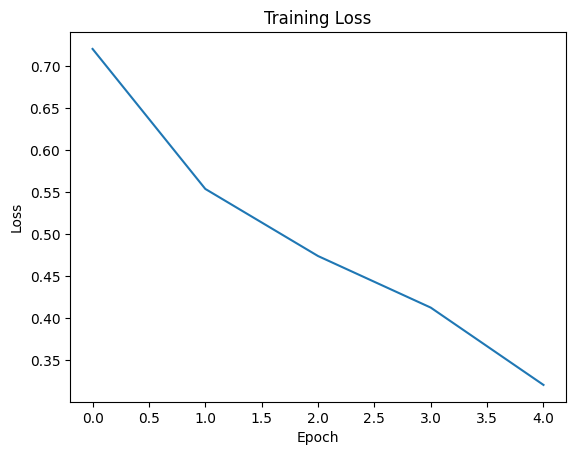

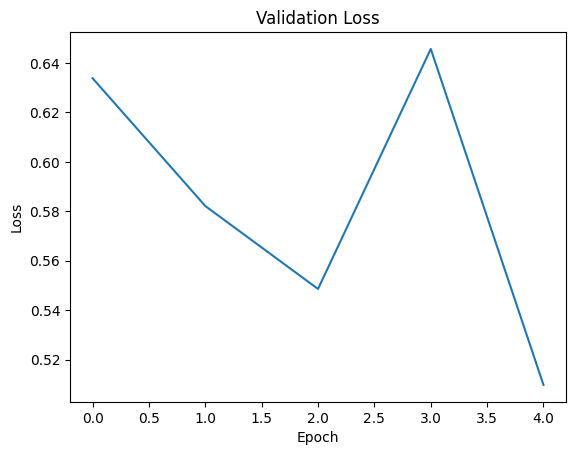

In [18]:
# Plot the loss for both training and validation

train_history = model.history.history

plt.title("Training Loss")
plt.ylabel("Loss")
plt.xlabel('Epoch')
plt.plot(train_history['loss'])
plt.show()

plt.title("Validation Loss")
plt.ylabel("Loss")
plt.xlabel('Epoch')
plt.plot(train_history['val_loss'])
plt.show()

### Evaluation

In [19]:
# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(test_generator, steps=test_generator.samples // test_generator.batch_size)

print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 18s 18s/step - accuracy: 0.6875 - loss: 0.7326
Test Loss: 0.7326
Test Accuracy: 0.6875


#### Visualize Predictions

In [20]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image

# Function to plot a single image and its prediction
def plot_image_with_title(image, model, true_label, predicted_label, class_names):
    plt.figure(figsize=(6, 6))
    plt.imshow(image)

    # Convert labels from one-hot to class indices if needed, but for binary labels it's just 0 or 1
    true_label_name = class_names[true_label]  # Labels are already in class indices
    pred_label_name = class_names[predicted_label]  # Predictions are 0 or 1

    plt.title(f"True: {true_label_name}\nPred: {pred_label_name}")
    plt.axis('off')
    plt.show()

# Function to test the model with images from the test set
def test_model_on_image(test_generator, model, index_to_plot=0):
    # Get a batch of images and labels from the test generator
    test_images, test_labels = next(test_generator)

    # Make predictions on the batch
    predictions = model.predict(test_images)

    # In binary classification, predictions are probabilities (float). Convert to binary (0 or 1)
    predicted_classes = (predictions > 0.5).astype(int).flatten()

    # Get the class indices from the test generator and invert them to get class names
    class_indices = test_generator.class_indices
    class_names = {v: k for k, v in class_indices.items()}  # Invert the dictionary

    # Specify the image to display based on the index
    image_to_plot = test_images[index_to_plot]
    true_label = test_labels[index_to_plot]
    predicted_label = predicted_classes[index_to_plot]

    # Plot the selected image with its true and predicted labels
    plot_image_with_title(image=image_to_plot, model=model, true_label=true_label, predicted_label=predicted_label, class_names=class_names)

1/1 ━━━━━━━━━━━━━━━━━━━━ 9s 9s/step


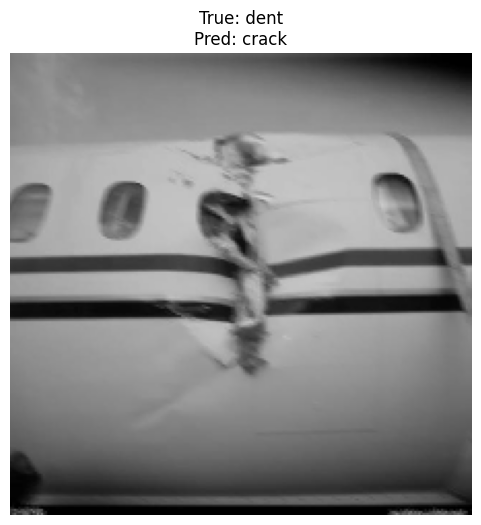

1/1 ━━━━━━━━━━━━━━━━━━━━ 18s 18s/step


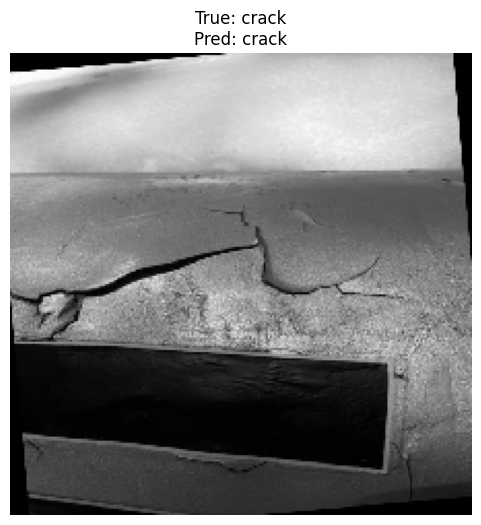

1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step


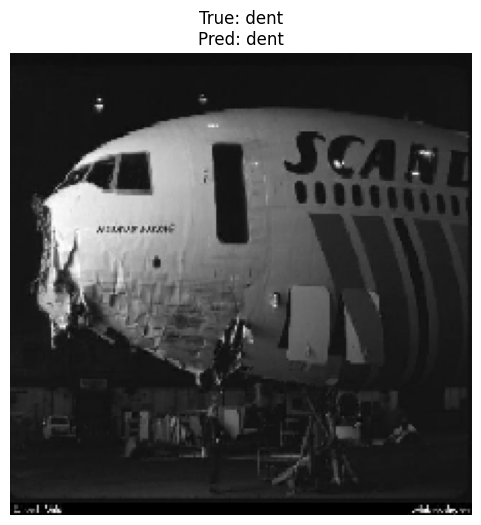

1/1 ━━━━━━━━━━━━━━━━━━━━ 18s 18s/step


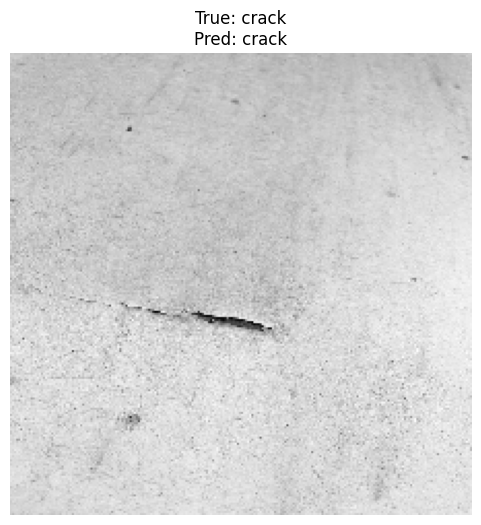

1/1 ━━━━━━━━━━━━━━━━━━━━ 9s 9s/step


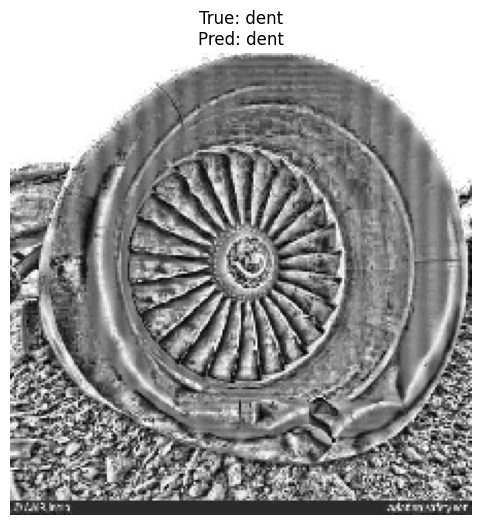

In [32]:
for i in range(1, 6):
    test_model_on_image(test_generator, model, index_to_plot=i)

## Image Captioning and Summarization using BLIP Pretrained Model

BLIP (Bootstrapping Language-Image Pretraining) is a vision-and-language model designed to generate natural language descriptions for images. It is specifically trained to understand images and their relationships to summarizing text, making it ideal for tasks like image captioning, summarization, and visual question answering.

We will use the BLIP model to build a system capable of generating captions and summary for images. The code will integrate the BLIP model within a custom Keras layer. This allows the user to input an image and specify a task, either "caption" or "summary", to receive a textual output that describes or summarizes the content of the image.

In [33]:
#Load the required libraries

import torch
import tensorflow as tf
from PIL import Image
from transformers import BlipProcessor, BlipForConditionalGeneration

### Load the BLIP Model and Processor from Hugging Face

Hugging Face is an open-source platform that provides pre-trained machine learning models, datasets, and tools, primarily focused on natural language processing, computer vision, and other AI tasks. It offers easy access to powerful models through its Transformers library.

- **BlipProcessor:** This handles the preprocessing of images and text. It converts images to the format that the BLIP model can understand.

- **BlipForConditionalGeneration:** This is the model itself, responsible for generating captions or summaries based on the processed image.

In [34]:
#load the pretrained BLIP processor and model:

processor = BlipProcessor.from_pretrained("Salesforce/blip-image-captioning-base")
model = BlipForConditionalGeneration.from_pretrained("Salesforce/blip-image-captioning-base")

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.
/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


preprocessor_config.json:   0%|          | 0.00/287 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/506 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/711k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/4.56k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/990M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/990M [00:00<?, ?B/s]

In [35]:
# Custom Keras Layer

class BlipCaptionSummaryLayer(tf.keras.layers.Layer):
    def __init__(self, processor, model, **kwargs):
        """
        Initialize the custom Keras layer with the BLIP processor and model.

        Args:
            processor: The BLIP processor for preparing inputs for the model.
            model: The BLIP model for generating captions or summaries.
        """
        super().__init__(**kwargs)
        self.processor = processor
        self.model = model

    def call(self, image_path, task):
        # Use tf.py_function to run the custom image processing and text generation
        return tf.py_function(self.process_image, [image_path, task], tf.string)

    def process_image(self, image_path, task):
        """
        Perform image loading, preprocessing, and text generation.

        Args:
            image_path: Path to the image file as a string.
            task: The type of task ("caption" or "summary").

        Returns:
            The generated caption or summary as a string.
        """
        try:
            # Decode the image path from the TensorFlow tensor to a Python string
            image_path_str = image_path.numpy().decode("utf-8")

            # Open the image using PIL and convert it to RGB format
            image = Image.open(image_path_str).convert("RGB")

            # Set the appropriate prompt based on the task
            if task.numpy().decode("utf-8") == "caption":
                prompt = "This is a picture of"  # Modify prompt for more natural output
            else:
                prompt = "This is a detailed photo showing"  # Modify for summary

            # Prepare inputs for the BLIP model
            inputs = self.processor(images=image, text=prompt, return_tensors="pt")

            # Generate text output using the BLIP model
            output = self.model.generate(**inputs)

            # Decode the output into a readable string
            result = self.processor.decode(output[0], skip_special_tokens=True)
            return result
        except Exception as e:
            # Handle errors during image processing or text generation
            print(f"Error: {e}")
            return "Error processing image"

In [36]:
# A Helper Function to Use the Custom Keras Layer

def generate_text(image_path, task):
  # Create an instance of the custom Keras layer
  # Replace this with the pretrained BLIP processor and model loaded earlier
    blip_layer = BlipCaptionSummaryLayer(processor, model)
    # Call the layer with the provided inputs
    return blip_layer(image_path, task)


### Generating Captions and Summaries

In [37]:
# Path to an example image
image_path = tf.constant("aircraft_damage_dataset_v1/test/dent/144_10_JPG_jpg.rf.4d008cc33e217c1606b76585469d626b.jpg")  # actual path of image

# Generate a caption for the image
caption = generate_text(image_path, tf.constant("caption"))
# Decode and print the generated caption
print("Caption:", caption.numpy().decode("utf-8"))

# Generate a summary for the image
summary = generate_text(image_path, tf.constant("summary"))
# Decode and print the generated summary
print("Summary:", summary.numpy().decode("utf-8"))

Caption: this is a picture of a plane
Summary: this is a detailed photo showing the engine of a boeing 747


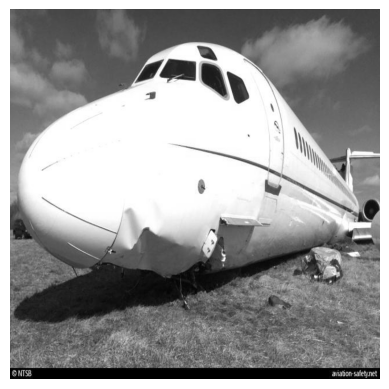

Caption: this is a picture of a plane that was sitting on the ground in a field
Summary: this is a detailed photo showing the damage to the fuselage of the aircraft


In [38]:
# We will use the following image to display Caption and Summary

# URL of the image
image_url = "aircraft_damage_dataset_v1/test/dent/149_22_JPG_jpg.rf.4899cbb6f4aad9588fa3811bb886c34d.jpg"

# Load and display the image
img = plt.imread(image_url)
plt.imshow(img)
plt.axis('off')  # Hide the axis
plt.show()

image_path = tf.constant("aircraft_damage_dataset_v1/test/dent/149_22_JPG_jpg.rf.4899cbb6f4aad9588fa3811bb886c34d.jpg")

# Generate a caption for the image
caption = generate_text(image_path, tf.constant("caption"))
# Decode and print the generated caption
print("Caption:", caption.numpy().decode("utf-8"))

# Generate a summary for the image
summary = generate_text(image_path, tf.constant("summary"))
# Decode and print the generated summary
print("Summary:", summary.numpy().decode("utf-8"))

